<a href="https://colab.research.google.com/github/YINZihua/yinzihua_PRIM_SSD_PyTorch/blob/main/PRIM3A_Image_Vision_Deepsort_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation for running Deepsort, cloned from official Deepsort Github repository

In [1]:
!git clone https://github.com/nwojke/deep_sort
%cd deep_sort

Cloning into 'deep_sort'...
remote: Enumerating objects: 141, done.
remote: Total 141 (delta 0), reused 0 (delta 0), pack-reused 141
Receiving objects: 100% (141/141), 66.79 KiB | 3.04 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/deep_sort


In [2]:
!pwd  # Colab: should be in the path "/content/deep_sort"

/content/deep_sort


Some code lines should be rewritten as the used functionalities are deprecated. Simply executed the following script lines is enough.

In [3]:
!sed -i "4c \from scipy.optimize import linear_sum_assignment as linear_assignment" deep_sort/linear_assignment.py

We would only make use of the DeepSort functionalities, so that we delete the code files of application examples provided by the original developper.

In [4]:
!rm deep_sort_app.py evaluate_motchallenge.py generate_videos.py show_results.py

Now download the SSD model pretrained by COCO dataset and the corresponding labels

In [5]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz

!tar -xzf ssd_inception_v2_coco_2018_01_28.tar.gz
!cp ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb .
!rm -r ssd_inception_v2_coco_2018_01_28/
!rm ssd_inception_v2_coco_2018_01_28.tar.gz

--2020-11-20 18:59:49--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5056 (4.9K) [text/plain]
Saving to: ‘mscoco_label_map.pbtxt’

mscoco_label_map.pb 100%[===================>]   4.94K  --.-KB/s    in 0s      

2020-11-20 18:59:49 (60.2 MB/s) - ‘mscoco_label_map.pbtxt’ saved [5056/5056]

--2020-11-20 18:59:49--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.170.128, 2607:f8b0:400c:c0d::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.170.128|:80... connected.
HTTP request sent, awaiting response... 200 OK


Some more utility functions provided by TensorFlow Project could be useful

In [6]:
# !mkdir external
# !mkdir external/object_detection
# !mkdir external/object_detection/utils
# !mkdir external/object_detection/protos

In [7]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/label_map_util.py -P external/object_detection/utils/
# !wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/visualization_utils.py -P external_util/
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/protos/string_int_label_map.proto -P external/object_detection/protos

--2020-11-20 19:00:00--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/utils/label_map_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12318 (12K) [text/plain]
Saving to: ‘external/object_detection/utils/label_map_util.py’

label_map_util.py   100%[===================>]  12.03K  --.-KB/s    in 0s      

2020-11-20 19:00:01 (103 MB/s) - ‘external/object_detection/utils/label_map_util.py’ saved [12318/12318]

--2020-11-20 19:00:01--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/protos/string_int_label_map.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

Before start the processing over videos, we should modify some of the DeepSort codes, in order to add up some extra functionalities.

track.py "def to_tlbr_norm(self,width,height):"

In [35]:
!sed -i "110a \        return tlbr_norm" deep_sort/track.py 
!sed -i "110a \        tlbr_norm[3] /= height" deep_sort/track.py 
!sed -i "110a \        tlbr_norm[2] /= width" deep_sort/track.py 
!sed -i "110a \        tlbr_norm[1] /= height" deep_sort/track.py 
!sed -i "110a \        tlbr_norm[0] /= width" deep_sort/track.py 
!sed -i "110a \        tlbr_norm = self.to_tlbr().copy()" deep_sort/track.py 
!sed -i "110a \    def to_tlbr_norm(self, width, height):" deep_sort/track.py 

# Establish a multi-camera people tracking applicaiton

## Import the necessary packages

In [36]:
from __future__ import division, print_function, absolute_import

import argparse
import os

import cv2
import numpy as np

import tensorflow as tf

from application_util import preprocessing
from application_util import visualization
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker

# from external.object_detection.utils import label_map_util

# from external_util import visualization_utils as vis_util


In [9]:
print('using Tensorflow version@'+str(tf.__version__))  # version@2.3.0 on Colab

using Tensorflow version@2.3.0


## Define the format of detections

In [10]:
class outputDetectionData():
  def __init__(self):
    self.bbox = np.asarray([])
    self.score_thresh = ()
    self.confidence = np.asarray([])
    self.classes = np.asarray([])
    # self.trame = np.asarray([]) # only used in ssdPredictor.getImage()
    self.category_box = ()
    # tracker_ids = np.asarray([])
    # tracked_bbox = np.asarray([])

## Define the class of SSD prediction by tensorflow

In [11]:
class ssdPredictor():
  def __init__(self,
          model_path,
          label_path,
          score_thresh,
          # image_data, # only used in getImage()
          # IMG_SCALE # only used to rescale the frame feed to model
          ):
    self.score_thresh = score_thresh
    # ...
    self.graph, self.sess = self.load_model(model_path)
    
    # ... (BEGIN) copy from omarabid59
    try:
      self.category_index, self.NUM_CLASSES = self.get_label_map(label_path)
    except: 
      self.category_index = None
      self.NUM_CLASSES = None
      print('Error: problem with label file path')


    [self.image_tensor, self.boxes_tensor,
     self.scores_tensor, self.classes_tensor,
     self.num_detections_tensor] = self.getTensors()

    # ... (END) copy from omarabid59
    self.output_data = outputDetectionData()
    self.output_data.score_thresh = score_thresh
    self.output_data.category_index = self.category_index


  def load_model(self,model_path):
    print('Loading Model File From: ' + model_path)

    # ... (BEGIN) copy from omarabid59-Deepsort-Tensorflow
    def get_graph(PATH_TO_MODEL):
      detection_graph = tf.Graph() 
      # tf.function() is recommanded to replace tf.Graph() (some deprecated functionalities should be used)
      with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(PATH_TO_MODEL,'rb') as f:
          serialized_graph = f.read()
          od_graph_def.ParseFromString(serialized_graph)
          tf.import_graph_def(od_graph_def,name='')
          return detection_graph
    
    def load_graph_with_sess(PATH_TO_MODEL):
      graph = get_graph(PATH_TO_MODEL)
      sess = tf.compat.v1.Session(graph=graph)
      return graph,sess
    # ... (END) copy from omarabid59-Deepsort-Tensorflow
    
    [graph,sess] = load_graph_with_sess(model_path)
    print('Finished Loading Model')
    return graph,sess

  # ... (BEGIN) copy from omarabid59


  def get_label_map(self, labels_path):
    with open(labels_path, "r") as f:
        file_content = f.read()

    data = file_content.split('item')
    output_data = {}
    num_classes = 0
    for indx, x in enumerate(data):
        if len(x) == 0:
            continue
        name = x.split('name:')[1].split('\n')[0].strip().replace('"','')
        _id = x.split('id:')[1].split('\n')[0].strip()
        display_name = x.split('display_name:')[1].split('\n')[0].strip().replace('"','')
        output_data[indx] = {
            'name':display_name,
            'id':_id,
            'display_name':name
        }
        num_classes += 1
    category_index = output_data
    return category_index, num_classes

  def getTensors(self):
    image_tensor = self.graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was
    # detected.
    boxes = self.graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = self.graph.get_tensor_by_name('detection_scores:0')
    classes = self.graph.get_tensor_by_name('detection_classes:0')
    num_detections = self.graph.get_tensor_by_name('num_detections:0')
    return [image_tensor, boxes, scores, classes, num_detections]


  def predict(self, image_np):
    # Actual detection.
    with self.sess.as_default(), self.graph.as_default():
      [boxes,scores,classes,temp_num_detections] = self.inferNN(image_np)
      # ... (BEGIN) always with no tracker

      # if self.WITH_TRACKER:
      #   [boxes, scores, classes] = self.runTracker(boxes, scores, classes, image_np.copy(), self.score_thresh)
      # else:
      boxes = np.squeeze(boxes)
      scores = np.squeeze(scores)
      classes = np.squeeze(classes)
      # Eliminate all values that do not meet the threshold.
      indices = [i for i, x in enumerate(scores > self.output_data.score_thresh) if x]
      scores = scores[indices]
      classes = classes[indices]
      boxes = boxes[indices]
      # ... (END) always with no tracker

      self.output_data.bbox = boxes
      self.output_data.scores = scores
      self.output_data.classes = classes
      # For now, we simply pass a reference to the image. We will use
      # this for predicting on the subset.
      self.output_data.img = image_np
      if self.output_data.bbox == ():
        self.output_data.bbox = np.asarray([])
      # time.sleep(0.1)
    return self.output_data

  # def runTracker(self, boxes, scores, classes, image_np, score_thresh): # This is a self-defined fucntionality by the original author, which we will not use here
  #   [temp_box, temp_score, temp_class,_] = self.global_tracker.pipeline(boxes, scores, classes, image_np, score_thresh=self.score_thresh)
  #   return [temp_box, temp_score, temp_class]

  def inferNN(self, image_np):
    '''
    Perform inference on the image
    '''
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3] ??? Where could I find this information
    image_np_expanded = np.expand_dims(image_np, axis=0)
    [boxes, scores, classes, temp_num_detections] = self.sess.run([self.boxes_tensor, self.scores_tensor,
                                      self.classes_tensor, self.num_detections_tensor],
                                      feed_dict = {self.image_tensor: image_np_expanded}
                                      )
    return [boxes, scores, classes, temp_num_detections]

  # def getImage(self):
  #   '''
  #   Returns the resized image that we will use for prediction.
  #   '''
  #   if self.IMG_SCALE < 1.0:
  #       self.output_data.image_np = cv2.resize(
  #           self.image_data.image_np.copy(), (0, 0),
  #           fx=self.IMG_SCALE, fy=self.IMG_SCALE)
  #   else:
  #       self.output_data.image_np = self.image_data.image_np
  #   return self.output_data.image_np
  # ... (END) copy from omarabid59

    # def predict(img):
    #   ...



In [14]:
# inputFileName = '...'
# outputFileName = '...'
ssdModelPath = 'frozen_inference_graph.pb'
ssdLabelPath = 'mscoco_label_map.pbtxt'
score_thresh = .5

In [42]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1N5WIzts7rAAENHtSuu4H7xpWI_kuxk5x', dest_path='./park.png')

im_test_bgr = cv2.imread('park.png')
im_test_rgb = im_test_bgr.copy()[:, :, ::-1]

predictor = ssdPredictor(model_path=ssdModelPath, label_path=ssdLabelPath,score_thresh=score_thresh)


Loading Model File From: frozen_inference_graph.pb
Finished Loading Model


In [17]:
im_test_bgr.shape

(527, 1081, 3)

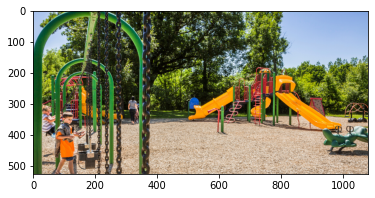

In [18]:
import matplotlib.pyplot as plt
plt.imshow(im_test_rgb)

In [19]:
output_test = predictor.predict(im_test_rgb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [20]:
print('bbox: '+str(output_test.bbox))
print('score_thresh: '+str(output_test.score_thresh))
print('scores: '+str(output_test.scores))
print('classes: '+str(output_test.classes))
# print('image_np: '+str(output_test.trame.shape))
print('category_index: '+str(output_test.category_index))


bbox: [[0.53181094 0.28690848 0.6967687  0.3193517 ]
 [0.6340171  0.04534865 0.9966259  0.14121097]
 [0.47160152 0.4608012  0.70518625 0.6132976 ]]
score_thresh: 0.5
scores: [0.79918396 0.580097   0.5375867 ]
classes: [ 1.  1. 38.]
category_index: {1: {'name': 'person', 'id': '1', 'display_name': '/m/01g317'}, 2: {'name': 'bicycle', 'id': '2', 'display_name': '/m/0199g'}, 3: {'name': 'car', 'id': '3', 'display_name': '/m/0k4j'}, 4: {'name': 'motorcycle', 'id': '4', 'display_name': '/m/04_sv'}, 5: {'name': 'airplane', 'id': '5', 'display_name': '/m/05czz6l'}, 6: {'name': 'bus', 'id': '6', 'display_name': '/m/01bjv'}, 7: {'name': 'train', 'id': '7', 'display_name': '/m/07jdr'}, 8: {'name': 'truck', 'id': '8', 'display_name': '/m/07r04'}, 9: {'name': 'boat', 'id': '9', 'display_name': '/m/019jd'}, 10: {'name': 'traffic light', 'id': '10', 'display_name': '/m/015qff'}, 11: {'name': 'fire hydrant', 'id': '11', 'display_name': '/m/01pns0'}, 12: {'name': 'stop sign', 'id': '13', 'display_name

## Define the class used for the DeepSort tracking processing

In [31]:
class DeepSort():
  def __init__(self,
         min_confidence=0.8,
         nms_max_overlap=1.0,
         min_detection_height=0.0,
         max_cosine_distance=0.2,
         nn_budget=None,
         max_age=5):
    self.min_confidence = min_confidence
    self.nms_max_overlap = nms_max_overlap
    self.min_detection_height = min_detection_height
    self.max_cosine_distance = max_cosine_distance
    self.nn_budget = nn_budget

    self.metric = nn_matching.NearestNeighborDistanceMetric("cosine", self.max_cosine_distance,self.nn_budget)
    self.tracker = Tracker(self.metric,max_age)

  def apply(self,frame,tracking):
    # ...
    hFrame,wFrame,_=frame.shape
    detections=[]
    
    # ... (BEGIN) copying from deep_sort_app.py

    for box, score in zip(tracking.bbox,tracking.scores):
      detections.append(Detection(box,score,frame)) # ??? should change the declaration of Detection()
    
    detections = [d for d in detections if d.confidence >= self.min_confidence]

    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, self.nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Update tracker
    self.tracker.predict()
    self.tracker.update(detections)

    # ... (END) copying from deep_sort_app.py

    # # ... We loop and store the confirmed trackers
    # tracking.tracker_ids = np.empty((0,))
    # tracking.tracked_bbox = np.empty((0,4))
    # for track in self.tracker.tracks:
    #   if not track.is_confirmed() or track.time_since_update>1:
    #     continue
    #   bbox = track.to_tlbr_norm(wFrame,hFrame)
    #   track_id = track.track_id
    #   tracking.tracked_bbox = np.append(tracking.tracked_bbox,np.array([bbox]),axis=0) # ??? not sure if it is on "axis=0", or if it needs np.array([bbox]) to get a 2-dim array to be concatenated
    #   tracking.tracker_ids = np.append(tracking.tracker_ids,track_id,axis=0) 
    #   # where are used and declared 'tracked_bbox' and 'tracker_ids' ?
    #   # They are newly declared here, and are used in box-drawing part,


    # ... (BEGIN) copy from omarabid59

    # # Count the number of confirmed trackers that we will output to the system
    # track_count = 0
    # # The first time we loop, we just count the number of confired trackers
    # for track in self.tracker.tracks:
    #     #if not track.is_confirmed() or track.time_since_update > 1:
    #     #    continue
    #     track_count +=1
    # tracking.tracker_ids = np.zeros(shape=(track_count))
    # tracking.tracked_bbox = np.zeros(shape=(track_count,4))
    # # The second time we loop, we store them
    # idx = 0
    # for track in self.tracker.tracks:
    #   if not track.is_confirmed() or track.time_since_update > 1:
    #       continue
    #   bbox = track.to_tlbr_norm(width, height)
    #   track_id = track.track_id
    #   tracking.tracked_bbox[idx] = bbox
    #   tracking.tracker_ids[idx] = track_id
    #   print('here')
    #   idx += 1
    # ... (END) copy from omarabid59
    
    # ... (TEST BEGIN)
    # length = len(tracking.bbox)
    # tracking.tracker_ids = np.zeros(shape=(length))
    # tracking.tracked_bbox = np.zeros(shape=(length,4))
    
    # ... (TEST END)
    
    return tracking



In [32]:
tracker_test = DeepSort()

In [33]:
output_test = tracker_test.apply(frame=im_test_bgr,tracking=output_test)

here


In [ ]:
hFrame,wFrame,_ = im_test_bgr.shape
for bbox in zip(output_test.bbox):
  cv2.rectangle(im_test_bgr,(int(bbox[0][0] * wFrame), int(bbox[0][1] * hFrame)),
               (int(bbox[0][2] * wFrame), int(bbox[0][3] * hFrame)),
               (0, 0, 255), 5)

In [38]:
# for bbox in zip(output_test.bbox):
#   print(str(bbox))
#   print([bbox[0][0], bbox[0][1], bbox[0][2], bbox[0][3]])

(array([0.53181094, 0.28690848, 0.6967687 , 0.3193517 ], dtype=float32),)
[0.53181094, 0.28690848, 0.6967687, 0.3193517]
(array([0.6340171 , 0.04534865, 0.9966259 , 0.14121097], dtype=float32),)
[0.6340171, 0.045348648, 0.9966259, 0.14121097]
(array([0.47160152, 0.4608012 , 0.70518625, 0.61329764], dtype=float32),)
[0.47160152, 0.4608012, 0.70518625, 0.61329764]


In [28]:
# outputFrame = drawBoxes(frame=im_test_bgr,tracking=output_test)

In [45]:
print(str(output_test.tracker_ids))
print(str(output_test.tracked_bbox))
print(str(output_test.bbox))


[]
[]
[[0.53181094 0.28690848 0.6967687  0.3193517 ]
 [0.6340171  0.04534865 0.9966259  0.14121097]
 [0.47160152 0.4608012  0.70518625 0.6132976 ]]


True

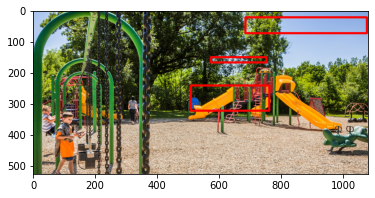

In [41]:
import matplotlib.pyplot as plt
outputFrame_rgb = im_test_bgr.copy()[:, :, ::-1]
plt.imshow(outputFrame_rgb)
cv2.imwrite('test.png',im_test_bgr)

In [87]:
output_test.tracker_ids

array([], dtype=float64)

In [27]:
def drawTrackedBoxes(frame,tracking):
  hFrame,wFrame,_ = frame.shape
  for id, bbox in zip(tracking.tracker_ids,tracking.tracked_bbox):
    cv2.rectangle(frame,(int(bbox[0] * wFrame), int(bbox[1] * hFrame)),
              (int(bbox[2] * wFrame), int(bbox[3] * hFrame)),
              (0, 0, 255), 5)
    cv2.putText(frame, "ID:"+str(id),
          (int(bbox[0] * wFrame), int(bbox[1] * hFrame + 50)),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  return frame

def drawBoxes(frame,tracking):
  if tracking.bbox.size > 0:
    frame_with_tracking = drawTrackedBoxes(frame,tracking)
  return frame_with_tracking

Now we could run a tracking session over several video examples.
<br>
<br> 

Firstly, download an example surveillance video file

In [50]:
!mkdir videos
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='...', dest_path='./videos/...')

# inputFileName = 'videos/...'
# outputFileName = 'videos/output.avi'
ssdModelPath = 'frozen_inference_graph.pb'
ssdLabelPath = 'mscoco_label_map.pbtxt'
score_thresh = .5

In [30]:
cap = cv2.VideoCapture(inputFileName)
predictor = ssdPredictor(model_path=ssdModelPath, label_path=ssdLabelPath,score_thresh=score_thresh)
tracker = DeepSort()

# take the first frame of the video
hFrame,wFrame,_ = frame.shape

# apply the tracking over several videos
outputVideo = cv2.VideoWriter(outputFileName,cv2.VideoWriter_fourcc(*"MJPG"),30,(wFrame,hFrame))
while True:
  ret, frame = cap.read()
  if ret == True:
    frameRGB = frame.copy()[:,:,::-1]
    tracking = predictor.predict(frameRGB)
    tracking = tracker.apply(frame=frame,tracking=tracking)
    trackResult = drawBoxes(frame=frame,tracking=tracking)
    outputVideo.write(trackResult)

  else:
    break

# cv2.destroyAllWindows()
cap.release()
outputVideo.release()

SyntaxError: ignored

# !!! the to_tlwh functionality is massively used in the original DeepSort for the compatibility with the MOTChallenge data set, while in the used SSD+DeepSort it is the to_tlbr principle more used. Don't forget to change it by 'sed' over the original DeepSort cloned files!!!

# try some demo code


In [46]:
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    if print_graph == True:
        print("-" * 50)
        print("Frozen model layers: ")
        layers = [op.name for op in import_graph.get_operations()]
        for layer in layers:
            print(layer)
        print("-" * 50)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))


In [61]:
test_images = cv2.imread('Reimagining-Parks-Home-Page_Foreground-Image_6-9-2020.png')

# Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("frozen_inference_graph.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                  inputs=['id'],
                  outputs=['name'],
                  print_graph=False)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Get predictions for test images
frozen_graph_predictions = frozen_func(x=tf.constant(test_images))[0]

# Print the prediction for the first image
print("-" * 50)
print("Example TensorFlow frozen graph prediction reference:")
print(frozen_graph_predictions[0].numpy())


KeyError: ignored